## Reproduces Extended Data Figure 4 in Lauer et al., Nature Methods 2022

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
sns.set_theme(style='ticks')

from deeplabcut.pose_estimation_tensorflow.lib import crossvalutils

%matplotlib inline

In [2]:
def plot_paf_performance(
    within, between, nbins=51, kde=True, colors=None, ax=None,
):
    bins = np.linspace(0, 1, nbins)
    if colors is None:
        colors = '#EFC9AF', '#1F8AC0'
    if ax is None:
        fig, ax = plt.subplots(tight_layout=True, figsize=(3, 3))
    sns.histplot(within, kde=kde, ax=ax, stat='probability',
                 color=colors[0], bins=bins)
    sns.histplot(between, kde=kde, ax=ax, stat='probability',
                 color=colors[1], bins=bins)
    return ax

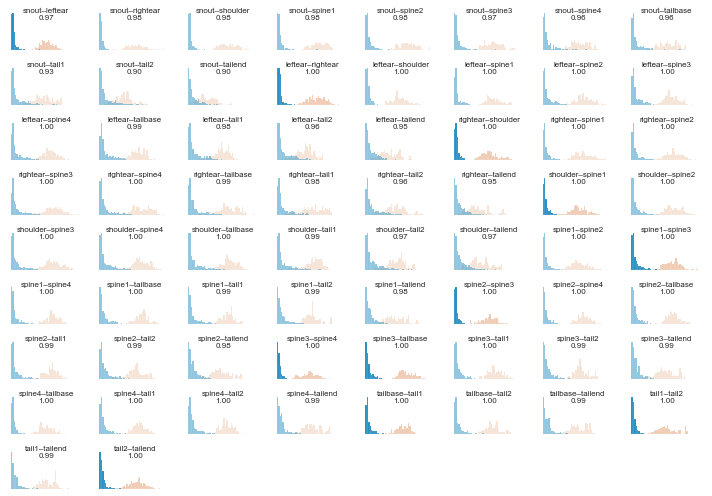

In [3]:
with open('../data/figS4/edges.pickle', 'rb') as file:
    data = pickle.load(file)
with open('../data/figS4/edges_meta.pickle', 'rb') as file:
    metadata = pickle.load(file)
(w_train, _), (b_train, _) = crossvalutils._calc_within_between_pafs(
    data, metadata,
)
data.pop('metadata', None)
nonempty = [i for i, vals in w_train.items() if vals]
w_train, b_train = zip(*[(w_train[i], b_train[i]) for i in nonempty])
meta = metadata['data']['DLC-model-config file']
bpts = list(map(str.lower, meta['all_joints_names']))
graph = [edge for i, edge in enumerate(meta['partaffinityfield_graph']) if i in nonempty]
nrows = int(np.ceil(np.sqrt(len(graph))))
ncols = int(np.ceil(len(graph) / nrows))
fig, axes_ = plt.subplots(nrows, ncols, figsize=(10, 7), tight_layout=True)
axes = axes_.flatten()
for ax in axes:
    ax.axis('off')
seps = []
for n, (w_tr, b_tr) in enumerate(
        zip(w_train, b_train)
):
    i1, i2 = graph[n]
    sep, th = crossvalutils._calc_separability(b_tr, w_tr, metric='auc')
    axes[n].text(0.5, 0.8, f'{bpts[i1]}–{bpts[i2]}\n{sep:.2f}', size=8,
                    ha='center', transform=axes[n].transAxes)
    plot_paf_performance(w_tr, b_tr, ax=axes[n], kde=False)
    seps.append(sep)
axes[0].set_xticks([])
axes[0].set_yticks([])
inds = [(0, 0), (1, 6), (1, 7), (2, 0), (3, 0), (3, 7), (4, 6), (5, 1), (7, 6), (8, 0), (8, 1)]
inds = np.ravel_multi_index(list(zip(*inds)), (9, 8))
inds = [51, 39, 45, 21, 52, 30, 11, 60, 63, 65, 0]
for i, ax in enumerate(axes):
    if i not in inds:
        for rect in ax.patches:
            rect.set_alpha(0.5)
    else:
        for rect in ax.patches:
            rect.set_alpha(1)
fig.savefig('figS4.jpg', dpi=600)

plt.show()